In [1]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
import analysis.lib.sim.electron_nuclear_sim as en_sim
reload(en_sim)
from scipy.stats import norm
%matplotlib inline

reloaded


In [50]:
time_duration = 50
pulse_center = 5
dt = 0.1
# FWHMs = np.linspace(0.1,3.5,5)
FWHMs = np.array([2.26]) #0.5,1.6,
mus = FWHMs/2.35482004503

repetitions = 3000

initial_excited_state_pop = 0.0
NV_lifetime = 12.0
decay_prob_per_step = dt/NV_lifetime

([<matplotlib.axis.XTick at 0xe994a58>,
 <a list of 5 Text xticklabel objects>)

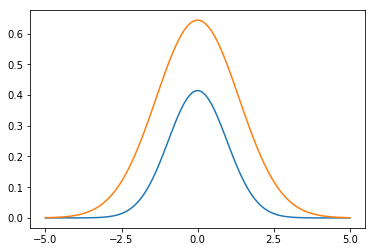

In [51]:
ts  = np.linspace(0,10,100)
plt.plot(ts-5,norm.pdf(ts, pulse_center, 2.26/2.35))
plt.plot(ts-5,np.sqrt(norm.pdf(ts, pulse_center, 2.26/2.35)))
plt.xticks([-5,-2.5,0,2.5,5])

In [57]:
init_state = en_sim.ket1.full()
zero_state = en_sim.ket0.full()
total_points = np.ceil(time_duration/np.float(dt) + 1).astype(int)
points = np.arange(total_points).astype(int)
t_array = dt * points
excited_pops = np.zeros([np.shape(mus)[0],total_points])
emitted_photons = np.zeros([np.shape(mus)[0],total_points])
double_pulse_probs = np.zeros(np.shape(mus)[0])
p_photon_during_pulse = np.zeros(np.shape(mus)[0])
p_photon_after_pulse = np.zeros(np.shape(mus)[0])

for kk,mu in enumerate(mus):
    pulse_cut = pulse_center + 3*mu
    pulse_cut_ind = np.argmin(np.abs(t_array - pulse_cut))

    pulse_EField_shape = np.sqrt(norm.pdf(t_array, pulse_center, mu))
    # Need to correct power to ensure full rabi
    EFieldFactor = 2*np.arcsin(np.sqrt(initial_excited_state_pop))/(2**(0.75) * (np.pi)**(0.25) * np.sqrt(mu))
    instaneous_rabi_freq = pulse_EField_shape*EFieldFactor
    unitary = np.zeros([total_points,2,2],dtype=complex)
    for ii in points:
        unitary[ii] = en_sim.spin_y_rotation(instaneous_rabi_freq[ii] * dt).full()

    excited_pop = np.zeros([repetitions,total_points])
    emitted_photon = np.zeros([repetitions,total_points])
    for jj in range(repetitions):
        decay_chance_for_step = np.random.rand(total_points)
        bright_state_chance_for_step = np.random.rand(total_points)
        state = init_state
        for ii in points:
            state =  np.dot(unitary[ii], state)
            excited_pop[jj,ii] = np.abs(state[1])**2
            if decay_chance_for_step[ii] < decay_prob_per_step:
                state = zero_state
                if bright_state_chance_for_step[ii] < excited_pop[jj,ii]:
                    emitted_photon[jj,ii] = 1

    excited_pops[kk] = np.mean(excited_pop,axis=0)
    emitted_photons[kk] = np.mean(emitted_photon,axis=0)
    photon_during_pulse = np.sum(emitted_photon[:,0:pulse_cut_ind],axis=1).astype(int)
    photon_after_pulse = np.sum(emitted_photon[:,pulse_cut_ind:],axis=1).astype(int)
    
    p_photon_during_pulse[kk] = np.mean(photon_during_pulse)
    p_photon_after_pulse[kk] = np.mean(photon_after_pulse)
    double_pulse_probs[kk] = np.mean(np.logical_and(photon_during_pulse,photon_after_pulse))

cond_prob_double_pulse = double_pulse_probs/p_photon_after_pulse


In [61]:
print t_array

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9  15.   15.1  15.2  15.3  15.4  15.5
  15.6  15.7  15.8  15.9  16.   16.1  16.2  16.3  1

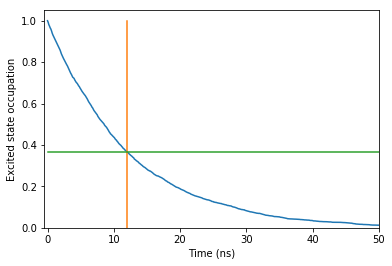

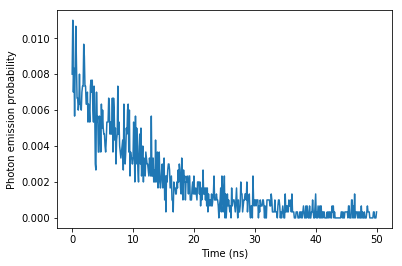

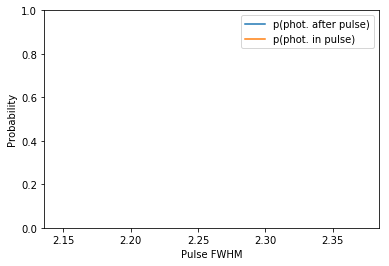

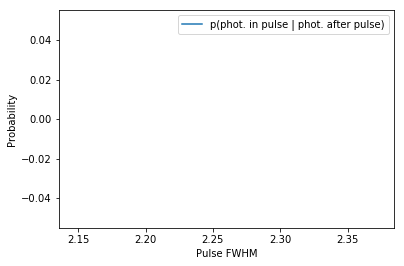

In [64]:
plt.figure()
plt.plot(t_array,np.transpose(excited_pops))
plt.plot([12,12],[0,1])
plt.plot([0,50],[np.exp(-1),np.exp(-1)])
plt.ylim([0,1.05]);
plt.xlim([-0.5,50])
plt.xlabel('Time (ns)')
plt.ylabel('Excited state occupation')

plt.figure()
plt.plot(t_array,np.transpose(emitted_photons))
plt.xlabel('Time (ns)')
plt.ylabel('Photon emission probability')

plt.figure()
plt.plot(FWHMs,p_photon_after_pulse,label = 'p(phot. after pulse)')
plt.plot(FWHMs,p_photon_during_pulse,label = 'p(phot. in pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.ylim([0,1]);
plt.legend()

plt.figure()
plt.plot(FWHMs,cond_prob_double_pulse,label = 'p(phot. in pulse | phot. after pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.legend();

In [24]:
print cond_prob_double_pulse

[ 0.01214128  0.02822086  0.03544304]


In [ ]:
p_photon_after_pulse